# Solar Energy Prediction
In this notebook we will try to predict the solar energy production using an LSTM model.

In [36]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

print('Pandas version:', pd.__version__) # 2.2.3
print('Numpy version:', np.__version__) # 1.26.4
print('TensorFlow version:', tf.__version__) # 2.18.0

Pandas version: 2.2.3
Numpy version: 1.26.4
TensorFlow version: 2.18.0


Right now this is just notebook just contains some test models, we still have to evaluate and improve them.

## Load the dataset

In [25]:
df = pd.read_csv('../data/Model/solar_production_weather.csv')
df

,Date,Time,WindDirection,WindSpeedAvg60min,WindGust,Temperature,Sunshineperhour,GlobalRadiation,HorizontalVisibility,CloudCover,AvgDailyTemperature,capacity,volume,percentage,emission,emissionfactor,Year,Month,Season
0,2021-01-01,01:00:00,230,10,20,-3.2,0,0,0,1,2.970833,0,0,0.0,0,0.0,2021,1,Winter
1,2021-01-01,02:00:00,230,20,30,-2.7,0,0,4,7,2.970833,0,0,0.0,0,0.0,2021,1,Winter
2,2021-01-01,03:00:00,220,20,30,-1.1,0,0,15,8,2.970833,0,0,0.0,0,0.0,2021,1,Winter
3,2021-01-01,04:00:00,230,20,40,1.1,0,0,18,8,2.970833,0,0,0.0,0,0.0,2021,1,Winter
4,2021-01-01,05:00:00,230,30,40,1.9,0,0,44,8,2.970833,0,0,0.0,0,0.0,2021,1,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26273,2023-12-31,18:00:00,200,70,150,8.6,0,0,75,8,8.829167,0,0,0.0,0,0.0,2023,12,Winter
26274,2023-12-31,19:00:00,200,80,140,8.6,0,0,75,8,8.829167,0,0,0.0,0,0.0,2023,12,Winter
26275,2023-12-31,20:00:00,200,70,150,8.2,0,0,70,8,8.829167,0,0,0.0,0,0.0,2023,12,Winter
26276,2023-12-31,21:00:00,200,70,140,8.1,0,0,70,8,8.829167,0,0,0.0,0,0.0,2023,12,Winter


In [26]:
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

df.drop(columns=['Date', 'Time'], inplace=True)

cols = ['Datetime'] + [col for col in df.columns if col != 'Datetime']
df = df[cols]
df.head()

,Datetime,WindDirection,WindSpeedAvg60min,WindGust,Temperature,Sunshineperhour,GlobalRadiation,HorizontalVisibility,CloudCover,AvgDailyTemperature,capacity,volume,percentage,emission,emissionfactor,Year,Month,Season
0,2021-01-01 01:00:00,230,10,20,-3.2,0,0,0,1,2.970833,0,0,0.0,0,0.0,2021,1,Winter
1,2021-01-01 02:00:00,230,20,30,-2.7,0,0,4,7,2.970833,0,0,0.0,0,0.0,2021,1,Winter
2,2021-01-01 03:00:00,220,20,30,-1.1,0,0,15,8,2.970833,0,0,0.0,0,0.0,2021,1,Winter
3,2021-01-01 04:00:00,230,20,40,1.1,0,0,18,8,2.970833,0,0,0.0,0,0.0,2021,1,Winter
4,2021-01-01 05:00:00,230,30,40,1.9,0,0,44,8,2.970833,0,0,0.0,0,0.0,2021,1,Winter


## Feature Selection
These features are selected based on the correlation that was created in the solar energy production eda notebook.

In [27]:
features = ['Temperature', 'Sunshineperhour', 'GlobalRadiation', 'CloudCover', 'HorizontalVisibility']
target = 'volume'

In [28]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = df[features + [target]]
scaled_data = scaler.fit_transform(scaled_data)

In [29]:
sequence_length = 72

X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, :-1]) 
    y.append(scaled_data[i, -1]) 

X = np.array(X)
y = np.array(y)

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

model.add(Dropout(0.2))

model.add(LSTM(50))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 72, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 72, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,451 (122.86 KB)

 Trainable params: 31,451 (122.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - loss: 0.0114 - val_loss: 0.0075
Epoch 2/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 0.0032 - val_loss: 0.0090
Epoch 3/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 0.0028 - val_loss: 0.0102
Epoch 4/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 0.0026 - val_loss: 0.0077
Epoch 5/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 0.0025 - val_loss: 0.0153
Epoch 6/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 0.0026 - val_loss: 0.0089
Epoch 7/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 0.0025 - val_loss: 0.0089
Epoch 8/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 0.0024 - val_loss: 0.0071
Epoch 9/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 0.0024 - val_loss: 0.0089
Epoch 10/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 0.0023 - val_loss: 0.0074
Epoch 11/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 0.0021 - val_loss: 0.0076
Epoch 12/100
656/65

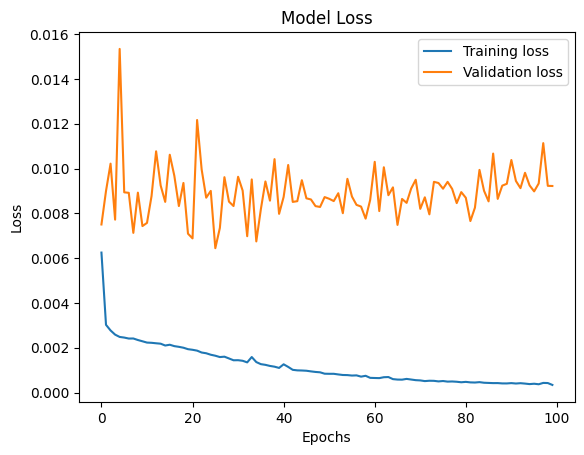

In [32]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [33]:
y_pred = model.predict(X_test)

y_test_actual = scaler.inverse_transform(np.hstack([X_test[:, -1, :], y_test.reshape(-1, 1)]))[:, -1]
y_pred_actual = scaler.inverse_transform(np.hstack([X_test[:, -1, :], y_pred.reshape(-1, 1)]))[:, -1]

from sklearn.metrics import mean_squared_error
import math

rmse = math.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
print(f'Root Mean Squared Error (RMSE): {rmse}')


164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Root Mean Squared Error (RMSE): 1616229.2066344626


In [34]:
df.describe()

,Datetime,WindDirection,WindSpeedAvg60min,WindGust,Temperature,Sunshineperhour,GlobalRadiation,HorizontalVisibility,CloudCover,AvgDailyTemperature,capacity,volume,percentage,emission,emissionfactor,Year,Month
count,26278,26278.000000,26278.000000,26278.000000,26278.000000,26278.000000,26278.000000,26278.000000,26278.000000,26278.000000,2.627800e+04,2.627800e+04,26278.000000,26278.0,26278.0,26278.000000,26278.000000
mean,2022-07-02 10:30:03.013927936,193.201918,33.127331,65.233275,11.278609,2.198227,45.528731,64.943489,6.043268,11.278377,1.997096e+06,1.997096e+06,0.138017,0.0,0.0,2021.999924,6.525611
min,2021-01-01 00:00:00,0.000000,0.000000,0.000000,-10.400000,0.000000,0.000000,0.000000,0.000000,-5.829167,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,2021.000000,1.000000
25%,2021-10-01 17:15:00,110.000000,20.000000,40.000000,6.500000,0.000000,0.000000,61.000000,4.000000,6.841667,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,2021.000000,4.000000
50%,2022-07-02 10:30:00,200.000000,30.000000,60.000000,10.900000,0.000000,2.000000,70.000000,8.000000,10.925000,6.682150e+04,6.682150e+04,0.004756,0.0,0.0,2022.000000,7.000000
75%,2023-04-02 03:45:00,260.000000,40.000000,80.000000,16.100000,3.000000,64.000000,75.000000,8.000000,16.433333,3.003533e+06,3.003533e+06,0.218114,0.0,0.0,2023.000000,10.000000
max,2023-12-31 22:00:00,990.000000,150.000000,310.000000,35.300000,10.000000,351.000000,83.000000,9.000000,26.866667,1.683231e+07,1.683231e+07,0.932454,0.0,0.0,2023.000000,12.000000
std,NaN,124.072629,17.734448,34.503155,6.698246,3.649901,73.348203,17.520688,3.050711,6.036346,3.174842e+06,3.174842e+06,0.211899,0.0,0.0,0.816497,3.447717


Root Mean Squared Error (RMSE): 1654523.719670854 (24h, ['Temperature', 'Sunshineperhour', 'GlobalRadiation'])

Root Mean Squared Error (RMSE): 1559449.636086062 (24h, ['Temperature', 'Sunshineperhour', 'GlobalRadiation', 'CloudCover', 'HorizontalVisibility'])

Root Mean Squared Error (RMSE): 1616229.2066344626 (72h, ['Temperature', 'Sunshineperhour', 'GlobalRadiation', 'CloudCover', 'HorizontalVisibility'])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

model = Sequential()

model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh'))
model.add(Dropout(0.3)) 

model.add(LSTM(64, return_sequences=True, activation='tanh'))
model.add(Dropout(0.3))

model.add(LSTM(32, activation='tanh'))
model.add(Dropout(0.2))

model.add(Dense(16, activation='relu'))

model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 72, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 72, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 72, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 72, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,905 (249.63 KB)

 Trainable params: 63,905 (249.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 26s 37ms/step - loss: 0.0131 - mae: 0.0749 - val_loss: 0.0153 - val_mae: 0.0704
Epoch 2/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - loss: 0.0039 - mae: 0.0380 - val_loss: 0.0100 - val_mae: 0.0569
Epoch 3/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - loss: 0.0035 - mae: 0.0347 - val_loss: 0.0115 - val_mae: 0.0578
Epoch 4/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - loss: 0.0031 - mae: 0.0321 - val_loss: 0.0112 - val_mae: 0.0596
Epoch 5/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - loss: 0.0032 - mae: 0.0320 - val_loss: 0.0086 - val_mae: 0.0515
Epoch 6/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - loss: 0.0028 - mae: 0.0295 - val_loss: 0.0100 - val_mae: 0.0564
Epoch 7/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - loss: 0.0027 - mae: 0.0294 - val_loss: 0.0097 - val_mae: 0.0532
Epoch 8/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - loss: 0.0026 - mae: 0.0280 - val_loss: 0.0102 - val_mae: 0.0548
Epoch 9/100
656/656 ━━━━━━━━━━━━

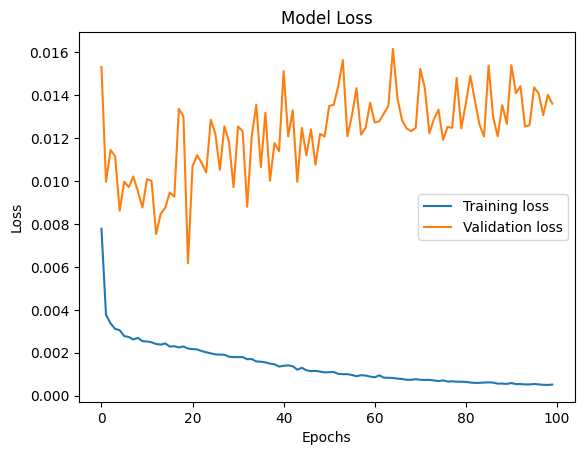

In [38]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [39]:
y_pred = model.predict(X_test)

y_test_actual = scaler.inverse_transform(np.hstack([X_test[:, -1, :], y_test.reshape(-1, 1)]))[:, -1]
y_pred_actual = scaler.inverse_transform(np.hstack([X_test[:, -1, :], y_pred.reshape(-1, 1)]))[:, -1]

from sklearn.metrics import mean_squared_error
import math

rmse = math.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
print(f'Root Mean Squared Error (RMSE): {rmse}')

164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Root Mean Squared Error (RMSE): 1963174.5478914587


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout

model_bidirectional = Sequential()

model_bidirectional.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model_bidirectional.add(Dropout(0.2))

model_bidirectional.add(Bidirectional(LSTM(64, return_sequences=False)))
model_bidirectional.add(Dropout(0.2))

model_bidirectional.add(Dense(32, activation='relu'))

model_bidirectional.add(Dense(1))

model_bidirectional.compile(optimizer='adam', loss='mean_squared_error')

model_bidirectional.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 72, 256)        │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 72, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,729 (1.17 MB)

 Trainable params: 305,729 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 67s 100ms/step - loss: 0.0084 - val_loss: 0.0120
Epoch 2/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 73s 111ms/step - loss: 0.0030 - val_loss: 0.0110
Epoch 3/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 72s 109ms/step - loss: 0.0026 - val_loss: 0.0082
Epoch 4/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 75s 114ms/step - loss: 0.0026 - val_loss: 0.0050
Epoch 5/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 74s 113ms/step - loss: 0.0025 - val_loss: 0.0092
Epoch 6/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 75s 114ms/step - loss: 0.0024 - val_loss: 0.0122
Epoch 7/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 69s 105ms/step - loss: 0.0025 - val_loss: 0.0087
Epoch 8/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 72s 110ms/step - loss: 0.0024 - val_loss: 0.0124
Epoch 9/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 72s 110ms/step - loss: 0.0023 - val_loss: 0.0068
Epoch 10/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 71s 108ms/step - loss: 0.0022 - val_loss: 0.0103
Epoch 11/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 71s 109ms/step - loss: 0.0021 - val_loss: 0.0088
Epoch 12

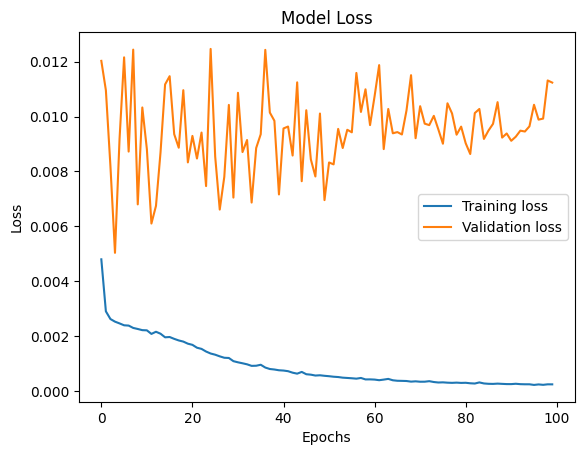

In [41]:
history = model_bidirectional.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [42]:
y_pred = model_bidirectional.predict(X_test)

y_test_actual = scaler.inverse_transform(np.hstack([X_test[:, -1, :], y_test.reshape(-1, 1)]))[:, -1]
y_pred_actual = scaler.inverse_transform(np.hstack([X_test[:, -1, :], y_pred.reshape(-1, 1)]))[:, -1]

from sklearn.metrics import mean_squared_error
import math

rmse = math.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
print(f'Root Mean Squared Error (RMSE): {rmse}')

164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step
Root Mean Squared Error (RMSE): 1784112.495899348


## Seasonal Trends

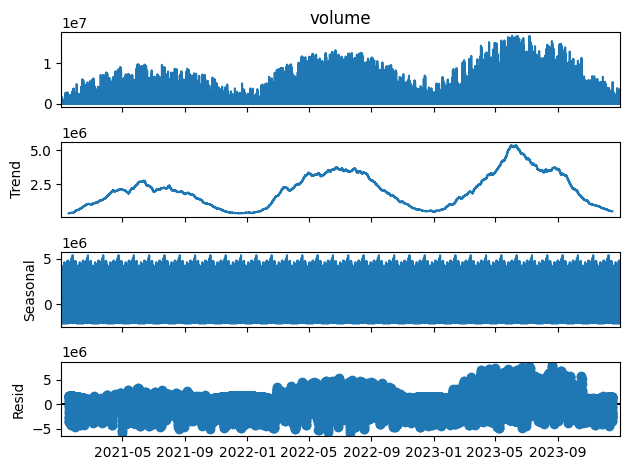

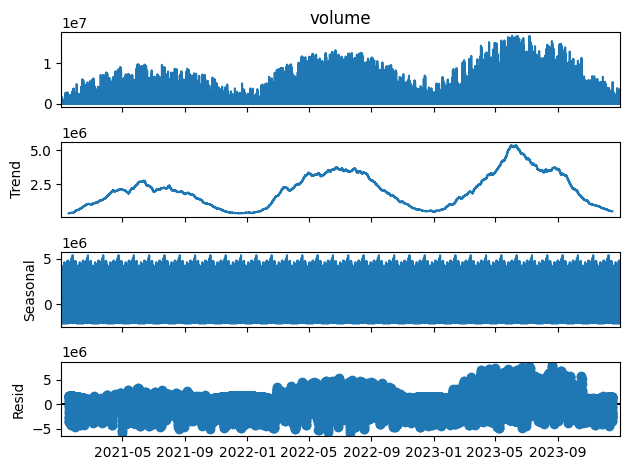

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

time_series = df['volume']

decompose_result = seasonal_decompose(time_series, model='additive', period=24*30)
decompose_result.plot()


In [ ]:
p, d, q = 2, 1, 2
P, D, Q, s = 1, 1, 1, 12

sarima_model = SARIMAX(time_series, 
                       order=(p, d, q), 
                       seasonal_order=(P, D, Q, s), 
                       enforce_stationarity=False, 
                       enforce_invertibility=False)
sarima_result = sarima_model.fit()

sarima_result.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has bee

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46089D+01    |proj g|=  4.23957D-01

At iterate    5    f=  1.45268D+01    |proj g|=  1.92850D-01

At iterate   10    f=  1.45069D+01    |proj g|=  1.84426D-01

At iterate   15    f=  1.44999D+01    |proj g|=  2.07250D-01

At iterate   20    f=  1.44822D+01    |proj g|=  4.09486D-01

At iterate   25    f=  1.44726D+01    |proj g|=  1.30261D-01

At iterate   30    f=  1.44722D+01    |proj g|=  2.45159D-02

At iterate   35    f=  1.44716D+01    |proj g|=  5.52101D-02

At iterate   40    f=  1.44715D+01    |proj g|=  2.64590D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                               volume   No. Observations:                26278
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood             -380283.000
Date:                              Tue, 17 Dec 2024   AIC                         760580.000
Time:                                      13:48:17   BIC                         760637.228
Sample:                                           0   HQIC                        760598.479
                                            - 26278                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7517      0.010    174.685      0.000       1.732       1.771
ar.L2         -0.8313      0.010    -82.122      0.000      -0.851      -0.811
ma.L1         -1.0451      0.013    -78.386      0.000      -1.071      -1.019
ma.L2          0.0460      0.013      3.452      0.001       0.020       0.072
ar.S.L12      -0.2684      0.020    -13.331      0.000      -0.308      -0.229
ma.S.L12      -0.9235      0.006   -148.801      0.000      -0.936      -0.911
sigma2      4.377e+11   1.33e-14   3.29e+25      0.000    4.38e+11    4.38e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):             41102.16
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               2.91   Skew:                             0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.41e+40. Standard errors may be unstable.
"""

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Root Mean Squared Error: 5605068.2487193635


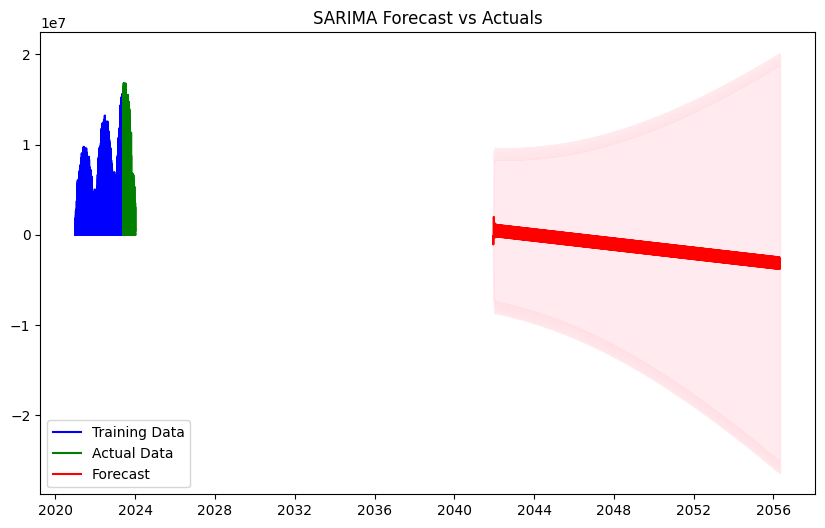

In [ ]:
train_size = int(len(time_series) * 0.8)
train, test = time_series[:train_size], time_series[train_size:]

forecast = sarima_result.get_forecast(steps=len(test))
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

rmse = np.sqrt(mean_squared_error(test, forecast_values))
print(f'Root Mean Squared Error: {rmse}')

plt.figure(figsize=(10, 6))
plt.plot(train, label='Training Data', color='blue')
plt.plot(test, label='Actual Data', color='green')
plt.plot(forecast_values, label='Forecast', color='red')
plt.fill_between(forecast_values.index, 
                 confidence_intervals.iloc[:, 0], 
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Forecast vs Actuals')
plt.legend()
plt.show()
